In [3]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  
from sklearn.datasets import load_svmlight_file

In [4]:
data_folder = './results'

## Portfolio problem

In [12]:
task_name = 'log_reg'
data_list =  problems = ['a4a','w4a','a1a','a2a','a3a','a5a','a6a','a7a','a8a','a9a','w1a','w2a','w3a','w5a','w6a','w7a','w8a']
policy_list = run_alpha_policies = ["standard","line_search","icml","backtracking", 'scopt']
policy_labels= ['Standard','Line Search','Ver1','Ver2','PN'] 
policy_to_policy_label = dict(zip(policy_list, policy_labels))
# policy_labels= ['Standard','Line Search','Ver1','Ver2','LLOO','PN']
results = dict()

for data_name in data_list:
    file_path = os.path.join(data_folder, task_name, data_name + '.pckl')
    with open(file_path, 'rb') as f:
        results[data_name] = pickle.load(f)

In [13]:
f_optim_values, error_hist_data, time_hist_data = {}, {}, {}

# calculate relative errors and save it (with time data)
for data_name in data_list:
    data_results = results[data_name][data_name]
    f_min = min([data_results[policy]['Q_hist'][-1] for policy in data_results.keys()])
    f_optim_values[data_name] = f_min
    for policy in data_results.keys():
        errors = [abs(f_val - f_min) / abs(f_min) for f_val in data_results[policy]['Q_hist']]
        if policy not in error_hist_data.keys():
            error_hist_data[policy] = {}
            time_hist_data[policy] = {}
        error_hist_data[policy][data_name] = np.array(errors)
        time_hist_data[policy][data_name] = np.array(data_results[policy]['time_hist'])

standard
line_search
icml
backtracking
scopt


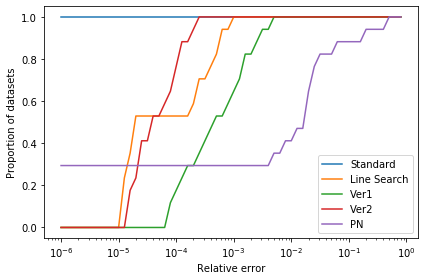

In [14]:
#dataset percentage plot
if not os.path.isdir('pics'):
    os.mkdir('pics')
policy_percentage_plot = {}
for policy in policy_list:
    print(policy)
    error_range = 10.0**np.arange(-6, 0, 0.1)
    achieved_error_data_qty = []
    for error_val in error_range:
        curr_error_achieved_qty = 0
        for error_hist in error_hist_data[policy].values():
            if (error_hist[-1] < error_val):
                curr_error_achieved_qty += 1
        achieved_error_data_qty.append(curr_error_achieved_qty)
    policy_percentage_plot[policy] = achieved_error_data_qty
    #print(policy,policy_percentage_plot[policy])
for policy in policy_percentage_plot:
    plt.plot(error_range, np.array(policy_percentage_plot[policy]) / len(data_list), label=policy_to_policy_label[policy])

plt.legend()
plt.xscale('log')
plt.xlabel('Relative error')
plt.ylabel(('Proportion of datasets'))
plt.tight_layout()
plt.savefig('./pics/dataset_proportion_plot.png')
plt.show()

In [56]:
error_hist_data['scopt']['a4a']

array([0.27615259, 0.27577071, 0.27538888, ..., 0.01575322, 0.01587015,
       0.01587015])

In [55]:
results['a4a']['a4a']['scopt'].keys()

dict_keys(['x', 'alpha_hist', 'Q_hist', 'time_hist'])

/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


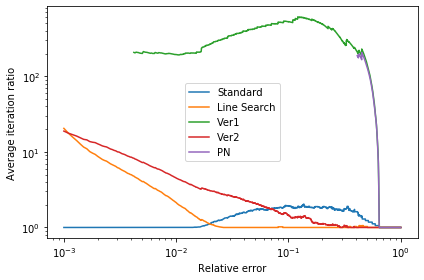

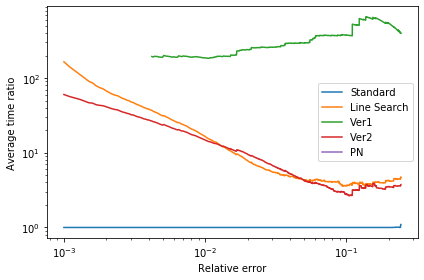

In [48]:
#average ratio iter plot
minimal_iter_per_algo = {}
minimal_time_per_algo = {}

for policy in error_hist_data.keys():
    error_range = np.arange(1e-3, 1, 1e-4)
    for data_name, error_hist in error_hist_data[policy].items():
        current_data_minimal_iters = []
        current_data_minimal_times = []
        for error_val in error_range:
            if any(error_hist < error_val):
                # find index of first error that lower than threshold (+1 since numeration starts from 0)
                iter_index = np.argmax(error_hist < error_val) + 1
                current_data_minimal_iters.append(iter_index)
                current_data_minimal_times.append(np.sum(time_hist_data[policy][data_name][:iter_index]))
            else:
                current_data_minimal_iters.append(np.nan)#len(error_hist))
                current_data_minimal_times.append(np.nan)#np.sum(time_hist_data[policy][data_name]))
        if policy not in minimal_iter_per_algo.keys():
            minimal_iter_per_algo[policy] = {}
            minimal_time_per_algo[policy] = {}
        minimal_iter_per_algo[policy][data_name] = current_data_minimal_iters
        minimal_time_per_algo[policy][data_name] = current_data_minimal_times

ratio_of_iter_per_algo = {}
ratio_of_time_per_algo = {}

for data_name in data_list:
    for i in range(len(error_range)):
        iters_over_policies = [minimal_iter_per_algo[policy][data_name][i] for policy in policy_list]
        times_over_policies = [minimal_time_per_algo[policy][data_name][i] for policy in policy_list]
        minimal_iter_val = min(iters_over_policies)
        minimal_time_val = min(times_over_policies)
        for policy in policy_list:
            if policy not in ratio_of_iter_per_algo.keys():
                ratio_of_iter_per_algo[policy] = {}
                ratio_of_time_per_algo[policy] = {}
            if data_name not in ratio_of_iter_per_algo[policy].keys():
                ratio_of_iter_per_algo[policy][data_name] = []
                ratio_of_time_per_algo[policy][data_name] = []
#             if np.isnan(minimal_iter_per_algo[policy][data_name][i]):
#                 print(f'{data_name}, {policy}: {minimal_iter_per_algo[policy][data_name][i]}, {minimal_iter_val}')
            ratio_of_iter_per_algo[policy][data_name].append(minimal_iter_per_algo[policy][data_name][i] / minimal_iter_val)
            ratio_of_time_per_algo[policy][data_name].append(minimal_time_per_algo[policy][data_name][i] / minimal_time_val)

for policy in policy_list:
    policy_avg_ratios = []
    for i in range(len(error_range)):
        policy_avg_ratios.append(np.mean([ratio_of_iter_per_algo[policy][data_name][i] for data_name in data_list]))
    plt.plot(error_range, policy_avg_ratios, label=policy_to_policy_label[policy])

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Relative error')
plt.ylabel('Average iteration ratio')
plt.legend()
plt.tight_layout()
plt.savefig('./pics/avg_iter_plot.png')
plt.show()

for policy in policy_list:
    policy_avg_time_ratios = []
    for i in range(len(error_range)):
        policy_avg_time_ratios.append(np.mean([ratio_of_time_per_algo[policy][data_name][i] for data_name in data_list]))
    plt.plot(error_range, policy_avg_time_ratios, label=policy_to_policy_label[policy])

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Relative error')
plt.ylabel('Average time ratio')
plt.legend()
plt.tight_layout()
plt.savefig('./pics/avg_time_plot.png')
plt.show()

/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  if sys.path[0] == '':
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  del sys.path[0]
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


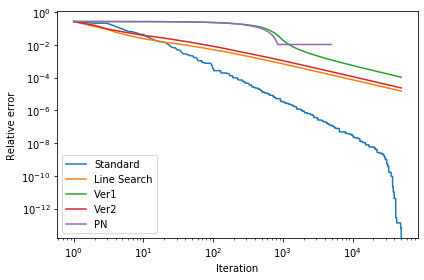

/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  if sys.path[0] == '':
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  del sys.path[0]
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


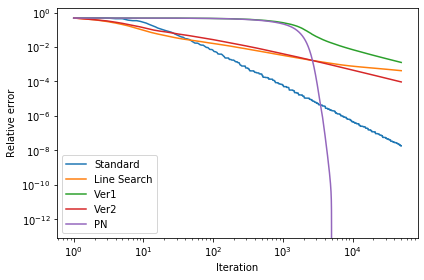

/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  if sys.path[0] == '':
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  del sys.path[0]
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


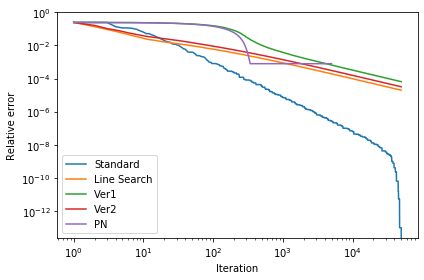

/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  if sys.path[0] == '':
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  del sys.path[0]
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


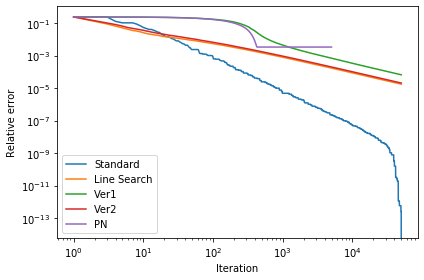

/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  if sys.path[0] == '':
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  del sys.path[0]
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


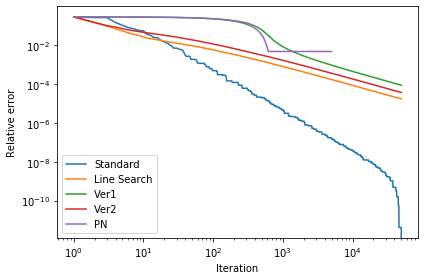

/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  if sys.path[0] == '':
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  del sys.path[0]
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


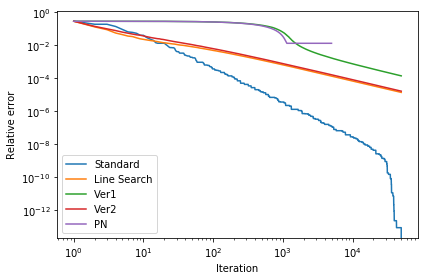

/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  if sys.path[0] == '':
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  del sys.path[0]
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


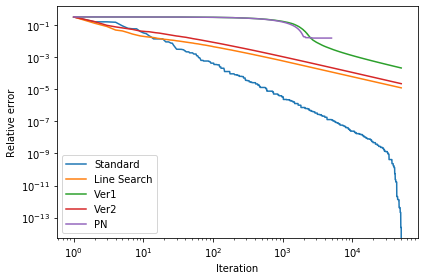

/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  if sys.path[0] == '':
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  del sys.path[0]
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


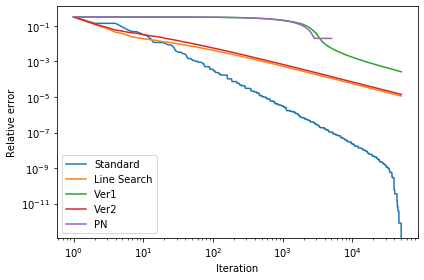

/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  if sys.path[0] == '':
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  del sys.path[0]
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


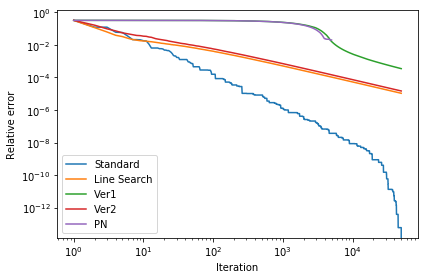

/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  if sys.path[0] == '':
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  del sys.path[0]
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


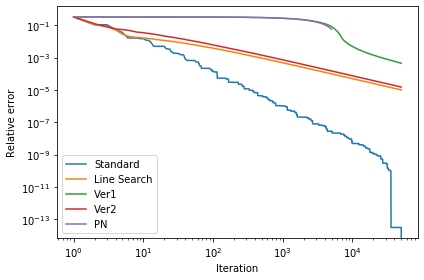

/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  if sys.path[0] == '':
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  del sys.path[0]
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


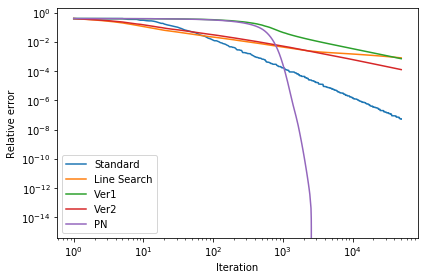

/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  if sys.path[0] == '':
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  del sys.path[0]
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


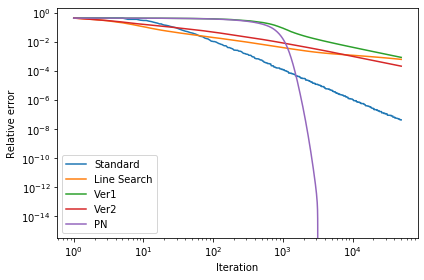

/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  if sys.path[0] == '':
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  del sys.path[0]
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


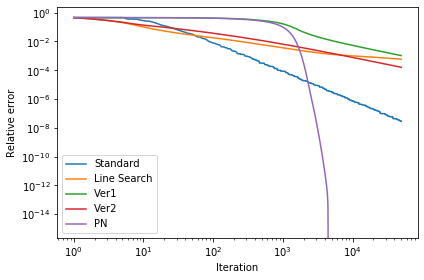

/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  if sys.path[0] == '':
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  del sys.path[0]
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


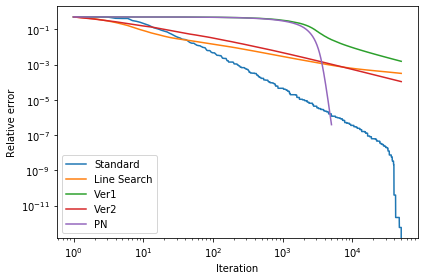

/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  if sys.path[0] == '':
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  del sys.path[0]
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


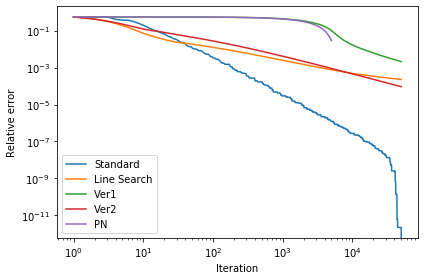

/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  if sys.path[0] == '':
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  del sys.path[0]
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


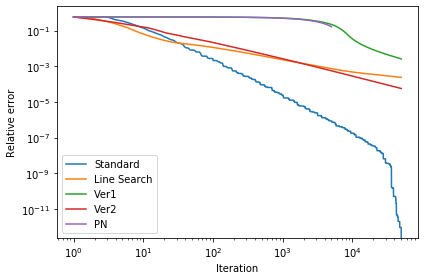

/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  if sys.path[0] == '':
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  del sys.path[0]
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


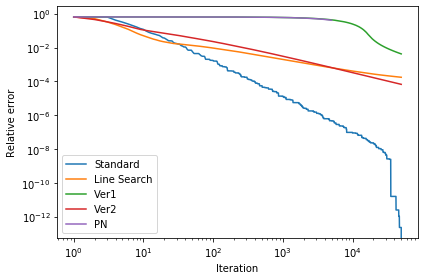

In [49]:
for data in data_list:
    for i in range(len(policy_list)):
        policy=policy_list[i]
        policy_label=policy_labels[i]
        series = pd.Series(error_hist_data[policy][data]) 
        plt.plot(range(1,len(error_hist_data[policy][data])+1),series.cummin(), label=policy_label)
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Relative error')
    plt.xscale('log')
    plt.yscale('log')
    plt.tight_layout()
    plt.savefig(os.path.join('./pics', data + 'error_vs_iter.png'))
    plt.show()

/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  from ipykernel import kernelapp as app
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  app.launch_new_instance()
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


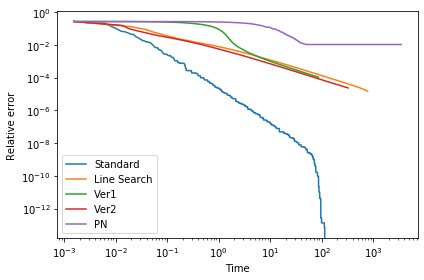

/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  from ipykernel import kernelapp as app
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  app.launch_new_instance()
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


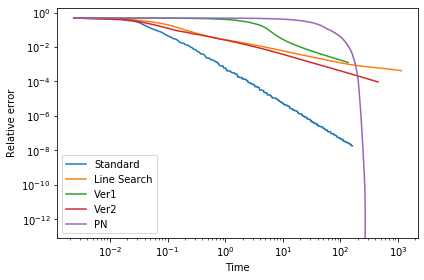

/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  from ipykernel import kernelapp as app
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  app.launch_new_instance()
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


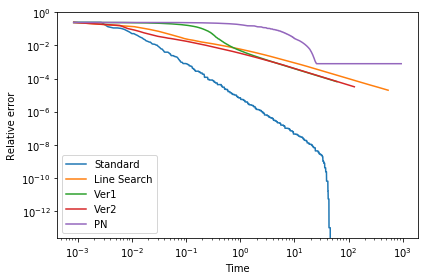

/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  from ipykernel import kernelapp as app
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  app.launch_new_instance()
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


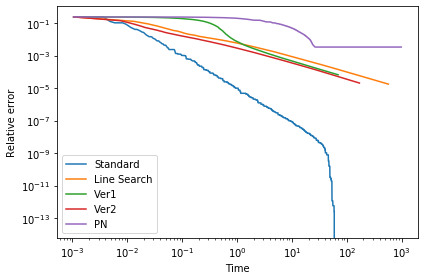

/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  from ipykernel import kernelapp as app
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  app.launch_new_instance()
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


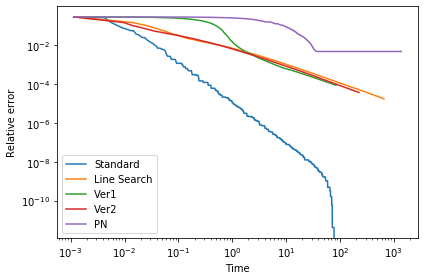

/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  from ipykernel import kernelapp as app
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  app.launch_new_instance()
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


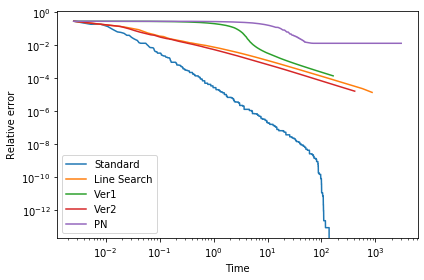

/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  from ipykernel import kernelapp as app
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  app.launch_new_instance()
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


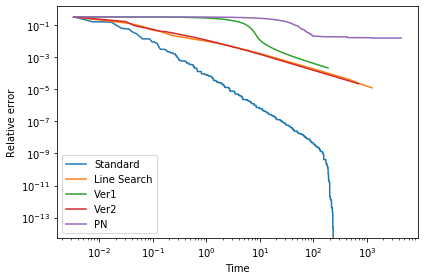

/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  from ipykernel import kernelapp as app
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  app.launch_new_instance()
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


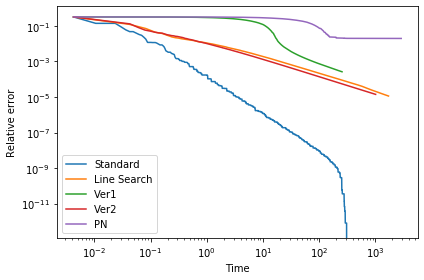

/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  from ipykernel import kernelapp as app
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  app.launch_new_instance()
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


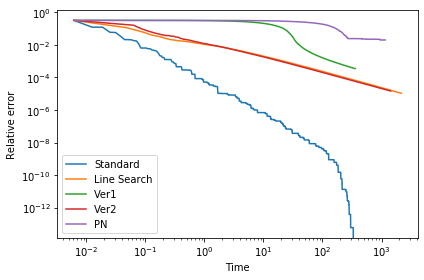

/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  from ipykernel import kernelapp as app
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  app.launch_new_instance()
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


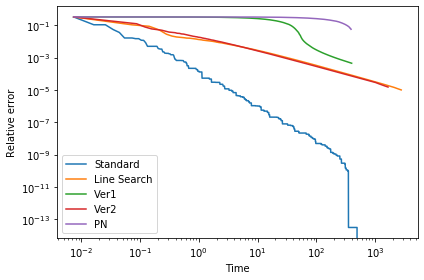

/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  from ipykernel import kernelapp as app
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  app.launch_new_instance()
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


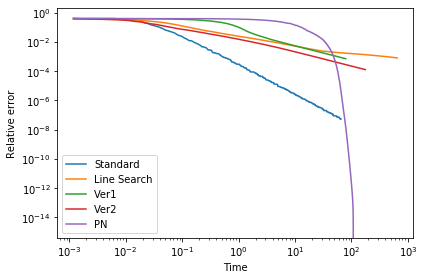

/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  from ipykernel import kernelapp as app
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  app.launch_new_instance()
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


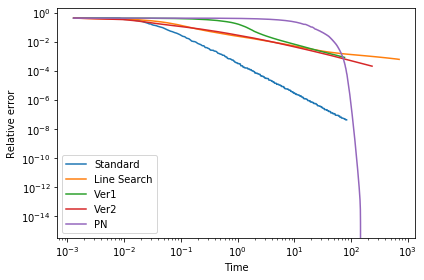

/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  from ipykernel import kernelapp as app
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  app.launch_new_instance()
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


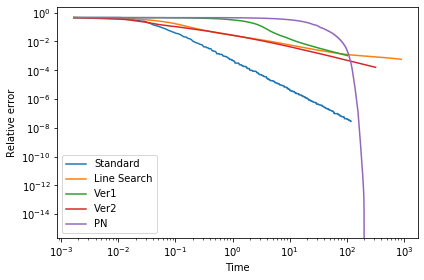

/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  from ipykernel import kernelapp as app
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  app.launch_new_instance()
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


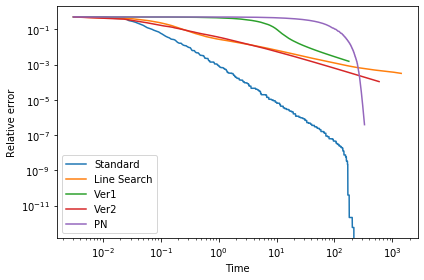

/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  from ipykernel import kernelapp as app
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  app.launch_new_instance()
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


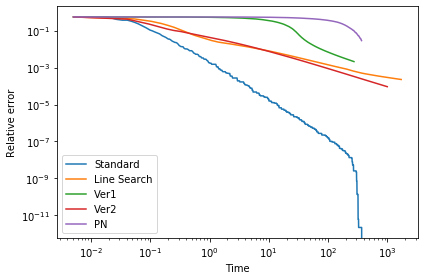

/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  from ipykernel import kernelapp as app
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  app.launch_new_instance()
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


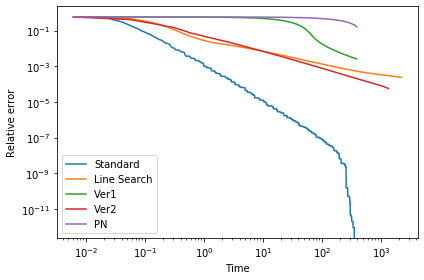

/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  from ipykernel import kernelapp as app
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  app.launch_new_instance()
/home/twlvth/.pyenv/versions/venv3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


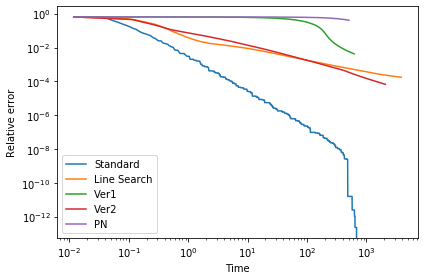

In [50]:
for data in data_list:
    min_time=10
    for policy in policy_list:
        min_time=np.minimum(min_time,np.min(time_hist_data[policy][data][1:]))
    for i in range(len(policy_list)):
        policy=policy_list[i]
        policy_label=policy_labels[i]
        series = pd.Series(error_hist_data[policy][data]) 
        plt.plot(np.cumsum(time_hist_data[policy][data])+min_time,series.cummin(), label=policy_label)
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Relative error')
    plt.xscale('log')
    plt.yscale('log')
    plt.tight_layout()
    plt.savefig(os.path.join('./pics', data + 'error_vs_time.png'))
    plt.show()

## Table

In [136]:
def get_table(results_data, error_hist_data, data_list, threshold):
    policies = ['scopt', 'standard', 'line_search', 'icml', 'backtracking']
    df_dict = {}
    dfs = []
    for p in policies:
        if p == 'scopt':
            columns = ['N', 'n', 'iter', 'time', 'error', 'time per iter', 'f_val']
        else:
            columns = ['iter', 'time', 'error', 'time per iter', 'f_val']
        for dn in sorted(data_list):
            data_path = os.path.join('data', dn)
            Phi, _ = load_svmlight_file(data_path)

            N, n = Phi.shape

            error_i = np.where(error_hist_data[policy][dn] >= threshold)[0][-1]
            error = error_hist_data[policy][dn][error_i]
            iter = error_i + 1
            time = sum(results_data[dn][dn][policy]['time_hist'][:error_i])
            time_per_iter = time / iter
            f_val = results_data[dn][dn][policy]['Q_hist'][error_i]
            
            if p == 'scopt':
                df_dict[dn] = [N, n, iter, time, round(error, 3), round(time_per_iter, 3), round(f_val, 3)]
            else:
                df_dict[dn] = [iter, time, round(error, 3), round(time_per_iter, 3), round(f_val, 3)]
        
        dfs.append(pd.DataFrame.from_dict(df_dict, orient='index', columns=columns))
    return pd.concat(dfs, axis=1)

In [128]:
threshold = 1e-2
df = get_table(results, error_hist_data, data_list, threshold)

In [135]:
df.to_clipboard()